# Homework 2
**Author: Morgan Byers**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime(current_val))

## Problem 1

In [3]:
#define derivatives
def s_dot(beta, I, gamma):
    return lambda S : (-1 * beta * S * I) + (gamma * I)

def i_dot(beta, gamma, S):
    return lambda I : (beta * S * I) - (gamma * I)

In [4]:
#solver
def solve(init_conditions, delta_t, max_time, beta, gamma):
    #set up experiment loop
    t = [init_conditions[0]]
    S =[init_conditions[1]]
    I = [init_conditions[2]]
    
    idx=0
    
    while t[idx] < max_time:
        #create derivatives
        s_update = s_dot(beta, I[idx], gamma)
        i_update = i_dot(beta, gamma, S[idx])
        
        #update S, I, R
        S.append(update(t[idx], delta_t, S[idx], s_update))
        I.append(update(t[idx], delta_t, I[idx], i_update))
    
        #upate time
        t.append(t[idx] + delta_t)
        idx += 1

    return t, S, I

### Part a

In [25]:
def plot(t, I, gamma, beta, delta_t, save=True):
    plt.plot(t, I, color='red', label = r'$i$')
    plt.hlines(1 - gamma / beta, t[0], t[-1], color='black', linestyle='dashed', label = r'$i_{eq}$')
    
    plt.ylim([0, 0.5])
    plt.xlim([t[0], t[-1]])
    
    plt.ylabel('Normalized Infections')
    plt.xlabel('Time')
    
    plt.title(rf'Infections over time, $\Delta t = {delta_t}$')
    plt.legend(loc='lower right')

    if save:
        plt.savefig(f'infections_delta={delta_t}.png', dpi=200, bbox_inches='tight')
    plt.show()

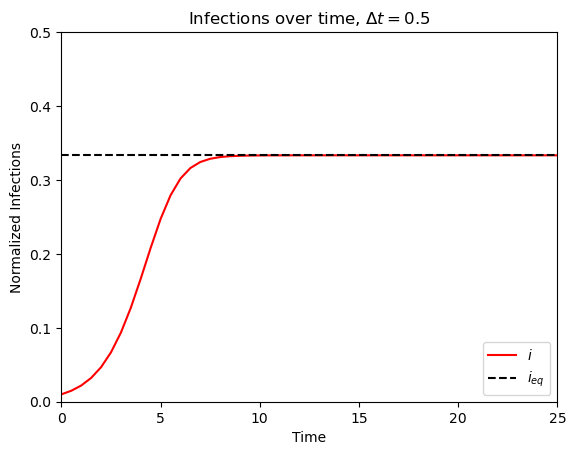

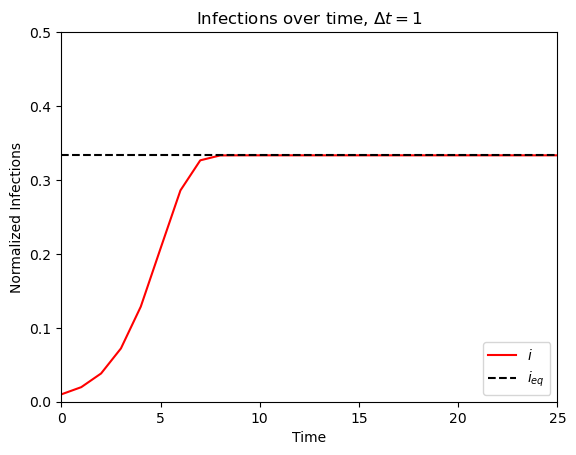

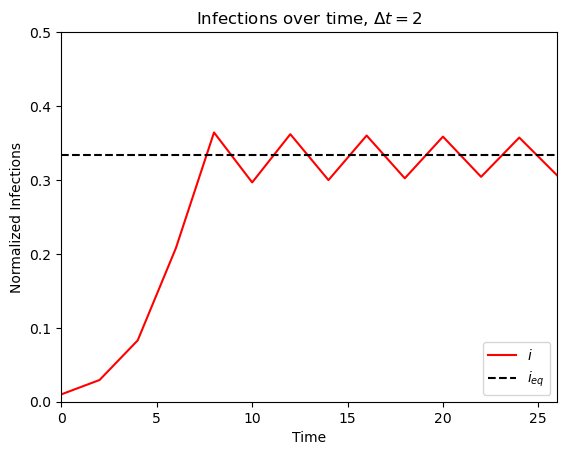

In [27]:
#set up initial conditions
s_init = 0.99
i_init = 0.01
t_init = 0

beta = 3
gamma = 2

delta_ts = [0.5, 1, 2]
max_t = 25

init_conditions = [t_init, s_init, i_init]

for delta_t in delta_ts:
    t, S, I = solve(init_conditions, delta_t, max_t, beta, gamma)
    plot(t, I, gamma, beta, delta_t)

### Part c

In [5]:
def error(i_euler, i_analytical):
    difference = np.subtract(i_euler, i_analytical)
    return np.max(np.abs(difference))

In [6]:
def i_analytical(i_init, beta, gamma):
    #we have a closed form solution for i
    R = beta / gamma
    numerator = 1 - (1 / (R))
    factor = (1 - (1 / R) - i_init) / i_init
    return lambda t: numerator / (1 + factor * np.exp(-(beta-gamma)*t))

def solve_analytical(init_conditions, delta_t, max_t, beta, gamma):
    t = [init_conditions[0]]
    #we don't care about s_0 here
    i = [init_conditions[2]]

    idx = 0

    #set up i's analytical solution
    i_solution = i_analytical(i[0], beta, gamma)

    while t[idx] < max_t:
        t.append(t[idx] + delta_t)
        i.append(i_solution(t[idx+1]))
        idx += 1

    return t, i

In [37]:
def plot(delta_ts, errors, save=True):
    plt.scatter(delta_ts, errors, color='black', s=4)
    
    plt.yscale('log')
    plt.xscale('log')
    
    plt.xlabel(r'$\Delta t$')
    plt.ylabel(r'$E(\Delta t)$')

    plt.xticks(delta_ts, labels=delta_ts)
    plt.yticks(errors, labels=[f'{e:.3f}' for e in errors])
    plt.minorticks_off()

    plt.title(r'$E(\Delta t)$ vs. $t$')

    if save:
        plt.savefig('errors_v_time.png', dpi=200, bbox_inches='tight')
    plt.show()

In [17]:
#set up initial conditions
s_init = 0.99
i_init = 0.01
t_init = 0

beta = 3
gamma = 2

delta_ts = [2, 1, 1/2, 1/4, 1/8, 1/16, 1/32]
max_t = 25

init_conditions = [t_init, s_init, i_init]
errors = []

#solve loop
for delta_t in delta_ts:
    t, _, i_euler = solve(init_conditions, delta_t, max_t, beta, gamma)
    t, i_analytical_sol = solve_analytical(init_conditions, delta_t, max_t, beta, gamma)

    errors.append(error(i_analytical_sol, i_euler))

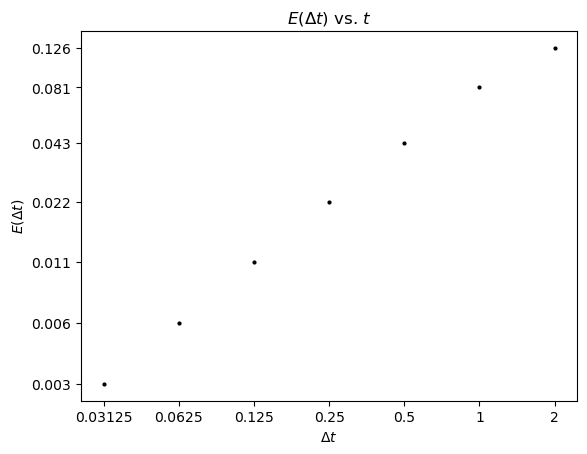

In [39]:
plot(delta_ts, errors, save=True)

## Problem 2

### All-Or-Nothing Dynamics

In [9]:
#define derivatives
def s_dot_aon(beta, i):
    return lambda s: -beta * s * i

def v_dot_aon(beta, i):
    return lambda v: -beta * v * i

def i_dot_aon(beta, gamma, s, v):
    return lambda i: (beta * s * i) + (beta * v * i) - (gamma * i)

def r_dot_aon(gamma, i):
    return lambda _: gamma * i

In [10]:
def svir_aon_solve(init_conditions, delta_t, max_time, beta, gamma):
    #set up experiment loop
    t = [0]
    s =[init_conditions[0]]
    v = [init_conditions[1]]
    i = [init_conditions[2]]
    r = [init_conditions[3]]
    
    idx=0
    
    while t[idx] < max_time:
        #create derivatives
        s_update = s_dot_aon(beta, i[idx])
        v_update = v_dot_aon(beta, i[idx])
        i_update = i_dot_aon(beta, gamma, s[idx], v[idx])
        r_update = r_dot_aon(gamma, i[idx])
        
        #update S, I, R
        s.append(update(t[idx], delta_t, s[idx], s_update))
        v.append(update(t[idx], delta_t, v[idx], v_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))
    
        #upate time
        t.append(t[idx] + delta_t)
        idx += 1

    return t, s, v, i, r

### Leaky dynamics

In [11]:
#define derivatives
def s_dot_leaky(beta, i):
    return lambda s: -beta * s * i

def v_dot_leaky(beta, i, VE):
    return lambda v: (-beta * v * i) * (1 - VE)

def i_dot_leaky(beta, gamma, s, v, VE):
    return lambda i: (beta * s * i) + (beta * v * i) * (1 - VE) - (gamma * i)

def r_dot_leaky(gamma, i):
    return lambda _: gamma * i

In [12]:
def svir_leaky_solve(init_conditions, delta_t, max_time, beta, gamma, VE):
    #set up experiment loop
    t = [0]
    s =[init_conditions[0]]
    v = [init_conditions[1]]
    i = [init_conditions[2]]
    r = [init_conditions[3]]
    
    idx=0
    
    while t[idx] < max_time:
        #create derivatives
        s_update = s_dot_leaky(beta, i[idx])
        v_update = v_dot_leaky(beta, i[idx], VE)
        i_update = i_dot_leaky(beta, gamma, s[idx], v[idx], VE)
        r_update = r_dot_leaky(gamma, i[idx])
        
        #update S, I, R
        s.append(update(t[idx], delta_t, s[idx], s_update))
        v.append(update(t[idx], delta_t, v[idx], v_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))
    
        #upate time
        t.append(t[idx] + delta_t)
        idx += 1

    return t, s, v, i, r

### Part b

In [14]:
#solve both models for all three values of R_0 and compare total cumulative infections
#set up initial conditions
N = 300000
VE = 0.8
fraction_vaxed = 0.5
gamma = 1/14

t_init = 0
delta_t = 0.125
max_t = 400

i_init = 1 / N
v_init = fraction_vaxed * (1 - VE)
s_init = 1 - i_init - fraction_vaxed
r_init = 0
init_conditions = [s_init, v_init, i_init, r_init]

R0s = [3, 4, 5]
#keeping track of results for this question and part c
i_aons = []
r_aons = []

for R0 in R0s:
    #find beta given r0 and gamma
    beta = R0 * gamma
    print(f'Beta = {beta:.3f}')

    t, s, v, i, r = svir_aon_solve(init_conditions, delta_t, max_t, beta, gamma)
    i_aons.append(i)
    r_aons.append(r)

Beta = 0.214
Beta = 0.286
Beta = 0.357


In [19]:
#set up initial conditions
N = 300000
VE = 0.8
fraction_vaxed = 0.5
gamma = 1/14

t_init = 0
delta_t = 0.125
max_t = 400

i_init = 1 / N
v_init = fraction_vaxed
s_init = 1 - i_init - v_init
r_init = 0
init_conditions = [s_init, v_init, i_init, r_init]

R0s = [3, 4, 5]
#more record keeping
i_leakys = []
r_leakys = []

for R0 in R0s:
    #find beta given r0 and gamma
    beta = R0 * gamma
    print(f'Beta = {beta:.3f}')

    t, s, v, i, r = svir_leaky_solve(init_conditions, delta_t, max_t, beta, gamma, VE)
    i_leakys.append(i)
    r_leakys.append(r)

Beta = 0.214
Beta = 0.286
Beta = 0.357


#### Comparing models

In [20]:
def compute_error(x, y):
    #compute the maximum difference betweent the two solutions
    return  np.max(np.abs(np.subtract(x, y)))

In [38]:
for idx in range(len(R0s)):
    print(f'R0 = {R0s[idx]}')
    max_error = compute_error(i_aons[idx], i_leakys[idx])
    total_infections_aon = r_aons[idx][-1]
    total_infections_leaky = r_leakys[idx][-1]
    
    print(f'\tMaximum error: {max_error:.3f}')
    print(f'\tAON cumulative infections: {total_infections_aon:.3f}')
    print(f'\tLeaky cumulative infections: {total_infections_leaky:.3f}')
    print(f'\tDifference in cumulative infections: {np.abs(total_infections_aon - total_infections_leaky):.3f}')
    print('-'*50)

R0 = 3
	Maximum error: 0.016
	AON cumulative infections: 0.439
	Leaky cumulative infections: 0.538
	Difference in cumulative infections: 0.099
--------------------------------------------------
R0 = 4
	Maximum error: 0.033
	AON cumulative infections: 0.527
	Leaky cumulative infections: 0.675
	Difference in cumulative infections: 0.148
--------------------------------------------------
R0 = 5
	Maximum error: 0.050
	AON cumulative infections: 0.565
	Leaky cumulative infections: 0.753
	Difference in cumulative infections: 0.189
--------------------------------------------------


### Part c

In [35]:
def plot(t, i_aon, i_leaky, N, R0, save=True):
    #for plotting the AON model results against the leaky model results from above
    I_aon = np.multiply(i_aon, N)
    plt.plot(t, I_aon, color='red', label='AON')
    I_leaky = np.multiply(i_leaky, N)
    plt.plot(t, I_leaky, color='blue', label='Leaky')

    plt.xlabel('Time')
    plt.ylabel('Infections')
    
    plt.xlim([t[0], t[-1]])
    plt.ylim([0, np.max([np.max(I_aon), np.max(I_leaky)]) + 5000])

    plt.title(rf'Infections Given $R_0 = {R0}$')
    plt.legend(loc='best')

    if save:
        plt.savefig(f'infections_r0={R0}_AON_v_leaky.png', dpi=200, bbox_inches='tight')
    plt.show()

R0 = 3
AON Max Infections: 21260.002
Leaky Max Infections: 25154.072


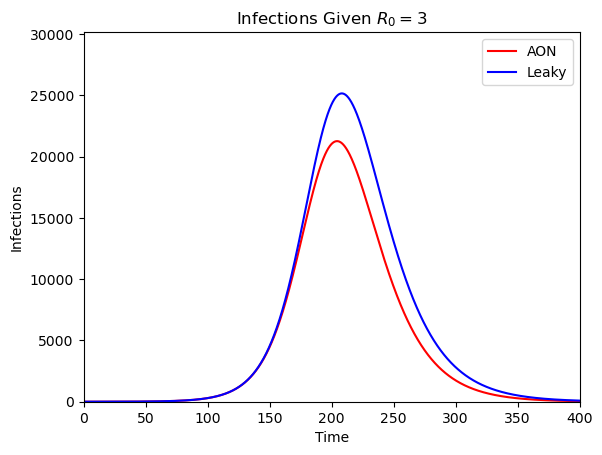

R0 = 4
AON Max Infections: 39446.858
Leaky Max Infections: 47318.963


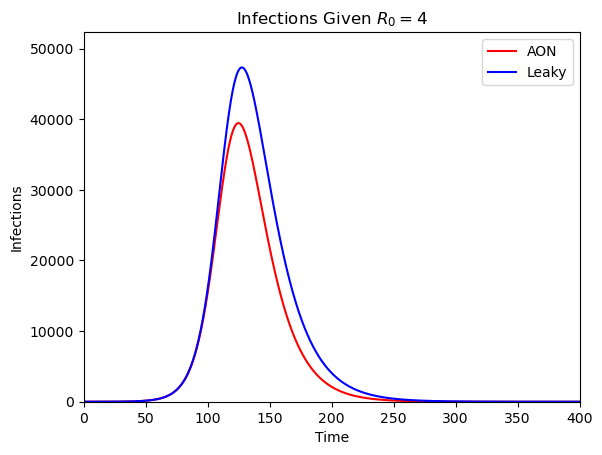

R0 = 5
AON Max Infections: 54269.579
Leaky Max Infections: 65845.403


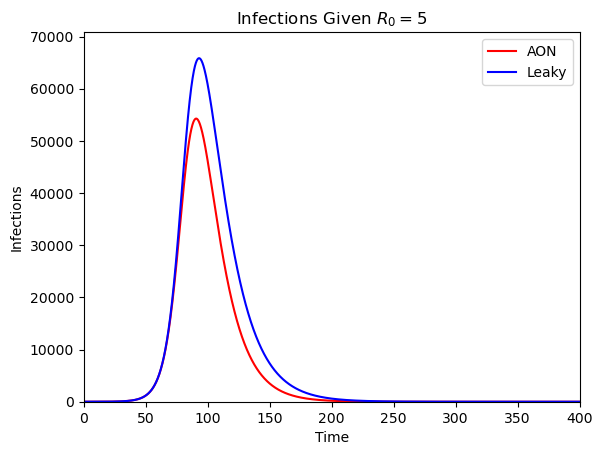

In [37]:
#t will not change across the model
for idx, R in enumerate(R0s):
    print(f'R0 = {R}')
    #comparing s_peak
    print(f'AON Max Infections: {np.max(i_aons[idx]) * N:.3f}')
    print(f'Leaky Max Infections: {np.max(i_leakys[idx]) * N:.3f}')
    plot(t, i_aons[idx], i_leakys[idx], N, R, save=True)